# network_analysis.py checker
First, import relevant libraries:

In [2]:
import os
import sys

sys.path.append('../../src/')
from utils.database import dbutils
from features.network_analysis import *

In [3]:
conn = dbutils.connect()
cursor = conn.cursor()

In [4]:
nodes = pd.read_sql('select * from optourism.firenze_card_locations', con=conn)
nodes.head()

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b


In [5]:
firenzedata = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
firenzedata.head()

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id
0,2070971,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38
1,2070972,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38
2,2071063,Palazzo Pitti Cumulativo,2016-08-08 11:40:00,0,1,1,0,38
3,2070258,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38
4,2069915,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38


In [6]:
df = prepare_firenzedata(firenzedata, nodes)
df.head()
# firenzedata['date'] = pd.to_datetime(firenzedata['entry_time'],format='%Y-%m-%d %H:%M:%S').dt.date  # Convert the entry_time string to a datetime object

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id,short_name,string,date,hour
0,2070971,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,39,Palazzo Pitti,P,2016-08-08,2016-08-08 11:00:00
1,2070972,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,39,Palazzo Pitti,P,2016-08-08,2016-08-08 11:00:00
2,2071063,Palazzo Pitti Cumulativo,2016-08-08 11:40:00,0,1,1,0,39,Palazzo Pitti,P,2016-08-08,2016-08-08 11:00:00
3,2070258,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,39,Palazzo Pitti,P,2016-08-08,2016-08-08 11:00:00
4,2069915,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,39,Palazzo Pitti,P,2016-08-08,2016-08-08 11:00:00


In [7]:
df['total_people'] = df['total_adults'] + df['minors']

In [8]:
edges = make_dynamic_firenze_card_edgelist(df)

In [9]:
static = make_static_firenze_card_edgelist(edges)

In [10]:
def make_firenze_card_static_graph_with_source(df,nodes,name='short_name',x='longitude',y='latitude'):
    """
    :param df: A static edgelist from above
    :param nodes: A data frame containing longitude and latitude
    :param name: the name on which to link the two data frames
    :param x: the longitude column name
    :param y: the latitude column name
    :return: an igraph graph object
    """
    g = ig.Graph.TupleList(df.itertuples(index=False), directed=True, weights=True)
    g.vs['indeg'] = g.strength(mode='in', weights='weight') # Save weighted indegree with dummy "source" node
#     g.delete_vertices([v.index for v in g.vs if v['name'] == u'source']) # Delete the dummy "source" node
    g.simplify(loops=False, combine_edges=sum) # Get rid of the few self-loops, which can plot strangely
    g.vs['label'] = g.vs["name"] # Names imported as 'name', but plot labels default to 'label'. Copy over.
    # Get coordinates, requires this lengthy query
    xy= pd.DataFrame({name: g.vs['label']}).merge(nodes[[name, x, y]], left_index=True, how='left', on=name)
    g.vs['x'] = (xy[x]).values.tolist()
    g.vs['y'] = (-1 * xy[y]).values.tolist() # Latitude is flipped, need to multiply by -1 to get correct orientation
    return g


In [12]:
g = make_firenze_card_static_graph_with_source(static,nodes)
ig.summary(g)

IGRAPH DNW- 42 1240 -- 
+ attr: indeg (v), label (v), name (v), x (v), y (v), weight (e)


In [13]:
mat = make_origin_destination_matrix(g)

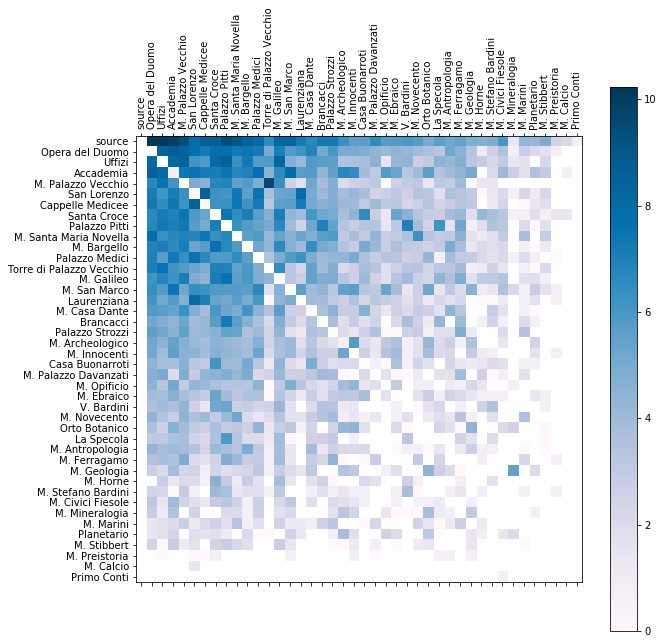

In [14]:
plot_origin_destination_matrix_heatmap(mat)

In [15]:
nodes.head()

,museum_name,longitude,latitude,museum_id,short_name,string
0,Basilica di Santa Croce,11.262598,43.768754,1,Santa Croce,C
1,Basilica San Lorenzo,11.254430,43.774932,2,San Lorenzo,2
2,Battistero di San Giovanni,11.254966,43.773131,3,Opera del Duomo,D
3,Biblioteca Medicea Laurenziana,11.253924,43.774799,4,Laurenziana,l
4,Cappella Brancacci,11.243859,43.768334,5,Brancacci,b


In [16]:
temp = mat.sum(0).to_frame() # This will be "people leaving", used as an offset for a Poisson regression
temp.reset_index(inplace=True)
temp.columns = ['short_name','offset']
temp.head()
dfn = nodes.merge(temp, on='short_name')[['museum_id','short_name','offset']]
dfn.head()

,museum_id,short_name,offset
0,1,Santa Croce,22979
1,2,San Lorenzo,20086
2,3,Opera del Duomo,49889
3,4,Laurenziana,7399
4,5,Brancacci,4488


In [17]:
temp = mat.sum(1).to_frame() # This will be "intrinsic popularity", total number of people entering the museum
temp.reset_index(inplace=True)
temp.columns = ['short_name','popularity']
temp.head()
dfn = dfn.merge(temp, on='short_name')[['museum_id','short_name','offset','popularity']]
dfn.head()

,museum_id,short_name,offset,popularity
0,1,Santa Croce,22979,13282
1,2,San Lorenzo,20086,16370
2,3,Opera del Duomo,49889,31738
3,4,Laurenziana,7399,7044
4,5,Brancacci,4488,3164


In [18]:
es = mat.stack().reset_index().rename(columns={'level_0':'source','level_1':'target', 0:'weight'})
es.head()

,source,target,weight
0,source,source,0
1,source,Opera del Duomo,27727
2,source,Uffizi,24845
3,source,Accademia,20073
4,source,M. Palazzo Vecchio,11219


In [ ]:
es.merge(dfn,)